In [1]:
# Prepare data (copied from PArt 1)
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns

lng_df_tmp = pd.read_csv('data/LNG.csv', index_col=0, parse_dates=[0])
spy_df_tmp = pd.read_csv('data/SPY.csv', index_col=0, parse_dates=[0])

lng_df = lng_df_tmp.loc['2016-04-15':'2018-04-16', :]
spy_df = spy_df_tmp.loc['2016-04-15':'2018-04-16', :]

# Create the 5-day future price (as 5d_future_close) with pandas' .shift().
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)

# Use pct_change() on 5d_future_close and Adj_Close to create the % price change 5 days in the future (5d_close_future_pct),
# and the current 5-day % price change (5d_close_pct).
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df.loc['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df['Adj_Close']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]


C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

# Engineering more features
## Feature engineering from volume
We're going to use non-linear models to make more accurate predictions. With linear models, features must be linearly correlated to the target. Other machine learning models can combine features in non-linear ways. For example, what if the price goes up when the moving average of price is going up, and the moving average of volume is going down? The only way to capture those interactions is to either multiply the features, or to use a machine learning algorithm that can handle non-linearity (e.g. random forests).

To incorporate more information that may interact with other features, we can add in weakly-correlated features. First we will add volume data, which we have in the `lng_df` as the `Adj_Volume` column.

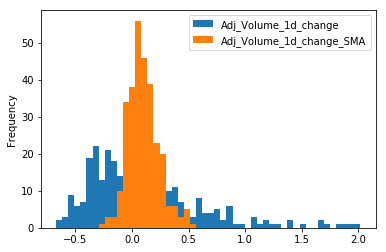

In [17]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
# Create a 1-day percent change in volume (use pct_change() from pandas), 
# and assign it to the Adj_Volume_1d_change column in lng_df.
lng_df['Adj_Volume_1d_change'] = lng_df['Adj_Volume'].pct_change()

# Create a 5-day moving average of the 1-day percent change in Volume, 
# and assign it to the Adj_Volume_1d_change_SMA column in lng_df.
lng_df['Adj_Volume_1d_change_SMA'] = talib.SMA(lng_df['Adj_Volume_1d_change'].values, timeperiod=5)

# Plot histograms of these two new features we created using the new_features list.
lng_df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()



## Create day-of-week features
We can engineer datetime features to add even more information for our non-linear models. Most financial data has datetimes, which have lots of information in them -- year, month, day, and sometimes hour, minute, and second. But we can also get the day of the week, and things like the quarter of the year, or the elapsed time since some event (e.g. earnings reports).

We are only going to get the day of the week here, since our dataset doesn't go back very far in time. The `dayofweek` property from the pandas datetime index will help us get the day of the week. Then we will dummy `dayofweek` with pandas' `get_dummies()`. This creates columns for each day of the week with binary values (0 or 1). We drop the first column because it can be inferred from the others.

In [15]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place
display(lng_df.head())

,Adj_Close,Adj_Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,,,,,,,,
2017-01-31,47.65,2137394.0,47.81,0.003358,0.043812,0.950697,62.968946,0.918657,60.655749,0.895731,57.951677,0.839267,53.695377,1,0,0,0
2017-02-01,47.10,2051631.0,48.01,0.019321,-0.023429,0.967486,60.156019,0.932427,59.159791,0.910110,57.041713,0.850150,53.487663,0,1,0,0
2017-02-02,49.33,3081369.0,49.19,-0.002838,-0.021618,0.932220,66.659314,0.895486,62.988478,0.873379,59.662227,0.812956,54.209475,0,0,1,0
2017-02-03,49.43,4158130.0,48.93,-0.010115,0.007336,0.938976,66.920059,0.899461,63.148741,0.875497,59.774509,0.812490,54.241479,0,0,0,1
2017-02-06,48.50,2090909.0,48.14,-0.007423,0.022129,0.964080,62.059184,0.921608,60.623276,0.895860,58.236185,0.829234,53.889442,0,0,0,0


## Examine correlations of the new features
Now that we have our volume and datetime features, we want to check the correlations between our new features (stored in the 'new_features' list) and the target ('5d_close_future_pct') to see how strongly they are related. Recall pandas has the built-in '.corr()' method for DataFrames, and seaborn has a nice 'heatmap()' function to show the correlations.

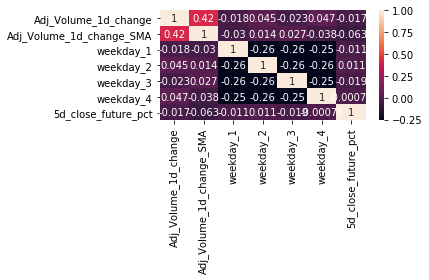

In [18]:
# Add the weekday labels to the new_features list
new_features.extend(['weekday_'+ str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(lng_df[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()